In [76]:
%autosave 60
import pandas as pd
import numpy as np
import datatable as dt
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE,MDS,Isomap
import random
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import csv
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.model_selection import GridSearchCV

Autosaving every 60 seconds


## load the data

In [2]:
x_train = dt.fread('bdi-cdt-machine-learning-genomics/train.csv/train.csv')
y_train = dt.fread('bdi-cdt-machine-learning-genomics/train.labels.csv')
x_test = dt.fread('bdi-cdt-machine-learning-genomics/test.csv/test.csv')

In [3]:
# convert to data frame
x_train = x_train.to_pandas()
x_test = x_test.to_pandas()
y_train = y_train.to_pandas()

In [4]:
print('The first 10 rows of the trainging dataset:')
x_train.head()

The first 10 rows of the trainging dataset:


SNP1  SNP2  SNP3  SNP4  SNP5  SNP6  SNP7  SNP8  SNP9  SNP10  ...  \
0     2     2     2     2     2     2     2     2     2      2  ...   
1     2     2     1     2     1     2     2     2     2      2  ...   
2     2     2     2     1     2     2     2     1     1      2  ...   
3     2     2     2     2     2     2     2     2     2      2  ...   
4     2     2     1     2     2     2     2     1     1      2  ...   

   SNP199991  SNP199992  SNP199993  SNP199994  SNP199995  SNP199996  \
0          2          2          2          2          2          2   
1          1          2          2          2          2          2   
2          2          2          2          2          2          2   
3          2          2          2          0          2          0   
4          2          2          2          2          2          2   

   SNP199997  SNP199998  SNP199999  SNP200000  
0          2          1          1          2  
1          2          1          1          2  
2          2          1          1          2  
3          0          2          2          2  
4          2          1          1          2  

[5 rows x 200000 columns]

In [5]:
print('the training dataset has the size', x_train.shape)
print('the test dataset has the size', x_test.shape)

the training dataset has the size (1252, 200000)
the test dataset has the size (1252, 200000)


In [6]:
# convert the categorical variables `population` to numeric codes
lbl = LabelEncoder()
y_train_numerical = y_train.apply(lbl.fit_transform)  # type:dataframe of shape (1252,1)

In [7]:
y_train_list = list(y_train_numerical['Population'])  # type: list of length 1252
l = len(y_train_list)

## data pre-processing

In [38]:
# Imputation of the train data
imp = SimpleImputer(missing_values = -2, strategy = 'most_frequent')
x_train = imp.fit_transform(x_train)

In [42]:
# pca for dimensionality reduction
time_start_pca = time.time()

pca = PCA(n_components=1252)
x_train_pca = pca.fit_transform(x_train)
print(x_train_pca.shape)

print('PCA time: {} seconds'.format(time.time()-time_start_pca))

(1252, 1252)
PCA time: 27.827535152435303 seconds


In [43]:
# apply the same pca transformation to the test dataset
x_test_pca = pca.transform(x_test)

In [53]:
pca_90 = PCA(n_components=0.9)
x_train_pca_90 = pca_90.fit_transform(x_train)
print(x_train_pca_90.shape)
x_test_pca_90 = pca_90.transform(x_test)

(1252, 1055)


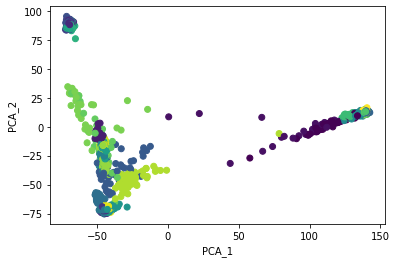

In [44]:
plt.scatter(x_train_pca[:, 0], x_train_pca[:, 1], c=y_train_list)
plt.xlabel('PCA_1')
plt.ylabel('PCA_2')
plt.show()

In [12]:
# MDS
time_start_mds = time.time()

mds = MDS(n_components=2)
x_train_mds = mds.fit_transform(x_train)
print(x_train_mds.shape)
print('MDS time: {} seconds'.format(time.time()-time_start_mds))


(1252, 2)
MDS time: 24.98114824295044 seconds


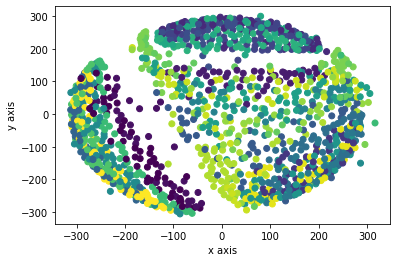

In [13]:
plt.scatter(x_train_mds[:, 0], x_train_mds[:, 1], c=y_train_list)
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.show()

In [69]:
#Isomap 
time_start_isomap = time.time()
isomap = Isomap(n_components=2)
x_train_isomap = isomap.fit_transform(x_train)
print(x_train_isomap.shape)
print('Isomap time: {} seconds'.format(time.time()-time_start_isomap))

(1252, 2)
Isomap time: 423.5228478908539 seconds


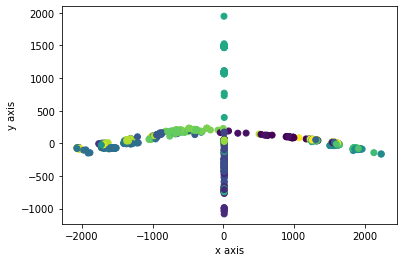

In [70]:
plt.scatter(x_train_isomap[:, 0], x_train_isomap[:, 1], c=y_train_list)
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.show()

In [71]:
x_test_isomap = isomap.transform(x_test)

In [16]:
# tSNE
time_start_tsne = time.time()
tsne = TSNE(n_components=2,perplexity=30.0)
x_train_tsne = tsne.fit_transform(x_train)
print('TSNE time: {} seconds'.format(time.time()-time_start_tsne))

TSNE time: 425.90242195129395 seconds


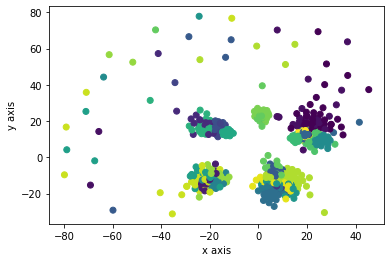

In [17]:
plt.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], c=y_train_list)
plt.xlabel('x axis')
plt.ylabel('y axis')
plt.show()

In [18]:
# kmeans with original training data
k_means = cluster.KMeans(n_clusters=5, init='k-means++', n_init=100, max_iter=300, tol=0.0001, precompute_distances='auto', verbose=0, random_state=None, copy_x=True, n_jobs=1, algorithm='auto')
val = k_means.fit(x_train_pca)

In [19]:
k_means_labels_pca = k_means.labels_
k_means_cluster_centers_pca = k_means.cluster_centers_

In [69]:
# visualization
def visual_plot_kmeans(k_means_labels, X, k_means_cluster_centers):
    fig = plt.figure(figsize=(10, 8))
    # Colors uses a color map, which will produce an array of colors based on
    colors = plt.cm.Spectral(np.linspace(0, 1, len(set(k_means_labels))))
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    # data point is in.
    for k, col in zip(range(k_means_cluster_centers.shape[0]), colors):
        my_members = (k_means_labels == k)
        print(k)
        # Define the centroid, or cluster center.
        if len(k_means_cluster_centers) <2:
            print('no center needed')
        else:
            cluster_center = k_means_cluster_centers[k]
        ax1.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.', markersize=12)
        if len(k_means_cluster_centers)<2:
            print('no center needed')
        else:
            ax1.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=15)

    ax2.scatter(X[:,0], X[:,1],  c = y_train_list, cmap = "jet", edgecolor = "None", alpha=0.35)
    ax1.set_title('KMeans')
    ax2.set_title('Actual clusters')
    ax1.set_xticks(())
    ax1.set_yticks(())
    ax2.set_xticks(())
    ax2.set_yticks(())
    plt.show()

0
1
2
3
4


<Figure size 720x576 with 0 Axes>

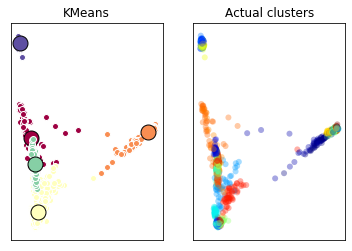

In [72]:
visual_plot_kmeans(k_means_labels_pca, x_train_pca, k_means_cluster_centers_pca)

## split the training dataset into training/validation

In [46]:
# 30% validation data and 70% training data
x_train1, x_val1, y_train1, y_val1 = train_test_split(x_train_pca, y_train, test_size = 0.30, random_state = 0)

print("Training set with feature selection has {} samples.".format(x_train1.shape[0]))
print("Testing set with feature selection has {} samples.".format(x_val1.shape[0]))

Training set with feature selection has 876 samples.
Testing set with feature selection has 376 samples.


In [66]:
# training data with dimension 1055
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train_pca_90, y_train, test_size = 0.30, random_state = 0)

print("Training set with feature selection has {} samples.".format(x_train2.shape[0]))
print("Testing set with feature selection has {} samples.".format(x_val2.shape[0]))

Training set with feature selection has 876 samples.
Testing set with feature selection has 376 samples.


## classification methods

In [47]:
# compute the prediction accuracy
def test_predict(clf, X_test, y_test): 
    results = {}
    predictions_test = clf.predict(X_test)
    accuracy=results['acc_test'] = accuracy_score(y_test, predictions_test)
    #fbeta=results['f_test'] = fbeta_score(y_test, predictions_test, beta = 0.5)
    
    print("accuracy for {} model is {}".format(clf.__class__.__name__,results['acc_test']))
    #print("F beta for {} model is {}".format(clf.__class__.__name__,results['f_test']))
    
    return results

### LDA

In [48]:
# fit the training data with LDA classifier
import warnings
warnings.filterwarnings('ignore')
clf_lda = LinearDiscriminantAnalysis()
clf_lda.fit(x_train1, y_train1)  

print('Accuracy of LinearDiscriminantAnalysis on training set: {:.2f}'.format(clf_lda.score(x_train1, y_train1)))
# prediction accuracy on validation data
val_LDA=test_predict(clf_lda, x_val1, y_val1)

Accuracy of LinearDiscriminantAnalysis on training set: 0.67
accuracy for LinearDiscriminantAnalysis model is 0.2473404255319149


In [49]:
# predict the test data
y_test_lda = clf_lda.predict(x_test_pca)
y_test_lda = list(y_test_lda)

### QDA

In [16]:
clf_qda = QuadraticDiscriminantAnalysis()
clf_qda.fit(x_train1, y_train1)  

print('Accuracy of QuadraticDiscriminantAnalysis on training set: {:.2f}'.format(clf_qda.score(x_train1, y_train1)))

Accuracy of QuadraticDiscriminantAnalysis on training set: 1.00


In [17]:
val_qda=test_predict(clf_qda, x_val1, y_val1)

accuracy for QuadraticDiscriminantAnalysis model is 0.20212765957446807


In [18]:
# predict the test data
y_test_qda = clf_qda.predict(x_test_pca)
y_test_qda = list(y_test_qda)

### logistic regression

In [19]:
clf_logi = LogisticRegression(random_state=0, solver='sag', multi_class='multinomial')
clf_logi.fit(x_train1, y_train1)  

print('Accuracy of Logistic regression on training set: {:.2f}'.format(clf_logi.score(x_train1, y_train1)))

Accuracy of Logistic regression on training set: 1.00


In [20]:
val_logi=test_predict(clf_logi, x_val1, y_val1)

accuracy for LogisticRegression model is 0.8218085106382979


In [21]:
# predict the test data
y_test_logi = clf_logi.predict(x_test_pca)
y_test_logi = list(y_test_qda)

In [22]:
clf_logi1 = LogisticRegression(random_state=0, solver='sag', multi_class='multinomial')
clf_logi2= LogisticRegression()
clf_logArray=[]
clf_logArray.append(clf_logi1)
clf_logArray.append(clf_logi2)
for i in range(len(clf_logArray)):
    scores = cross_val_score(clf_logArray[i], x_train_pca, y_train, cv=10)
    score=scores.mean()
    print("for logistic reg type{}, score is {}".format(i, score))

for logistic reg type0, score is 0.8367970885382194
for logistic reg type1, score is 0.5860708279546408


### KNN

In [23]:
clf_knn = KNeighborsClassifier(n_neighbors=10,algorithm='auto')
scores = cross_val_score(clf_knn, x_train_pca, y_train, cv=10)
score=scores.mean()
print(score)

0.4372781277297699


In [24]:
full_accList = list()
k_max = 30
for k in range(1,k_max+1):
    clf_knn = KNeighborsClassifier(n_neighbors=k,algorithm='auto')
    scores = cross_val_score(clf_knn, x_train_pca, y_train, cv=10)
    score=scores.mean()
    full_accList.append(score)

The prediction accuracies with different choices of k are: [0.34787039218919047, 0.3375902474208262, 0.34319914347904895, 0.35647331581572994, 0.36875229240198254, 0.42105222717242513, 0.4321892565058981, 0.42170493294607264, 0.4292549057884698, 0.4372781277297699, 0.4351540741296067, 0.45101372801637246, 0.46764845078225115, 0.4742536632108679, 0.48504232358803606, 0.5013484957137845, 0.5154294618403169, 0.5199026763392997, 0.5150841406073414, 0.5212152100485478, 0.5154291411105747, 0.52803330898845, 0.5258615369721099, 0.5273591061961614, 0.5232256545595197, 0.5251641673924509, 0.5290777228692197, 0.5296741700179968, 0.5223622068018771, 0.526161783925749]


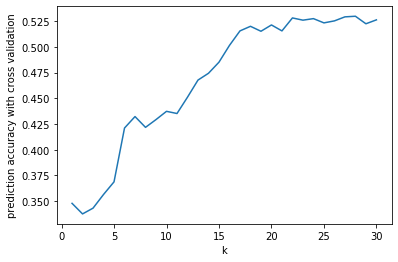

In [25]:
print('The prediction accuracies with different choices of k are:',full_accList)
plt.plot([k for k in range(1,k_max+1)],full_accList)
plt.xlabel('k')
plt.ylabel('prediction accuracy with cross validation')
plt.show()

In [26]:
# based on the result above, we choose k = 10 approximately
clf_knn = KNeighborsClassifier(n_neighbors=10,algorithm='auto')
clf_knn.fit(x_train1, y_train1)  
print('Accuracy of K Nearest Neighbors on training set: {:.2f}'.format(clf_knn.score(x_train1, y_train1)))

Accuracy of K Nearest Neighbors on training set: 0.60


In [27]:
val_knn=test_predict(clf_knn, x_val1, y_val1)

accuracy for KNeighborsClassifier model is 0.46808510638297873


In [28]:
# predict the test data
y_test_knn = clf_knn.predict(x_test_pca)
y_test_knn = list(y_test_knn)

### Naïve Bayes classifier

In [61]:
from sklearn.naive_bayes import GaussianNB
clf_nb = GaussianNB()
clf_nb = clf_nb.fit(x_train1, y_train1)

print('Accuracy of Naïve Bayes classifier on training set: {:.2f}'.format(clf_nb.score(x_train1, y_train1)))

Accuracy of Naïve Bayes classifier on training set: 1.00


In [62]:
val_svm = test_predict(clf_svm, x_val1, y_val1)

accuracy for SVC model is 0.7553191489361702


### SVM

In [50]:
from sklearn import svm
clf_svm = svm.SVC(kernel='linear', gamma='scale', C=1000) # Linear Kernel [linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable]
clf_svm.fit(x_train1, y_train1)
print('Accuracy of K Nearest Neighbors on training set: {:.2f}'.format(clf_svm.score(x_train1, y_train1)))

Accuracy of K Nearest Neighbors on training set: 1.00


In [51]:
val_svm = test_predict(clf_svm, x_val1, y_val1)

accuracy for SVC model is 0.7553191489361702


In [65]:
# compare the prediction accuracy with differ
clf_svm1 = svm.SVC(kernel='sigmoid', gamma='scale', C=1)
clf_svm2 = svm.SVC(kernel='sigmoid', gamma='scale', C=5)
clf_svm3 = svm.SVC(kernel='sigmoid', gamma='scale', C=10)
clf_svm4 = svm.SVC(kernel='sigmoid', gamma='‘auto_deprecated', C=1000)


clf_svmArray=[]
clf_svmArray.append(clf_svm1)
clf_svmArray.append(clf_svm2)
clf_svmArray.append(clf_svm3)
#clf_svmArray.append(clf_svm4)


for i in range(len(clf_svmArray)):
    scores = cross_val_score(clf_svmArray[i], x_train_pca, y_train, cv=10)
    score=scores.mean()
    print("for svm type{}, score is {}".format(i, score))

for svm type0, score is 0.5805701201520928
for svm type1, score is 0.84464836380546
for svm type2, score is 0.84464836380546


In [67]:
# compare the prediction accuracy with differ
clf_svm1_90 = svm.SVC(kernel='sigmoid', gamma='scale', C=1)
clf_svm2_90 = svm.SVC(kernel='sigmoid', gamma='scale', C=5)
clf_svm3_90 = svm.SVC(kernel='sigmoid', gamma='scale', C=10)
clf_svm4 = svm.SVC(kernel='sigmoid', gamma='‘auto_deprecated', C=1000)


clf_svmArray_90=[]
clf_svmArray_90.append(clf_svm1_90)
clf_svmArray_90.append(clf_svm2_90)
clf_svmArray_90.append(clf_svm3_90)
#clf_svmArray.append(clf_svm4)


for i in range(len(clf_svmArray_90)):
    scores = cross_val_score(clf_svmArray_90[i], x_train_pca_90, y_train, cv=10)
    score=scores.mean()
    print("for svm type{}, score is {}".format(i, score))

for svm type0, score is 0.6837951565291887
for svm type1, score is 0.8507940269633334
for svm type2, score is 0.8507940269633334


In [ ]:
"""
def svc_param_selection(X, y, nfolds):
    kernel = ['linear','sigmoid']
    
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_
"""

In [57]:
clf_svm4.fit(x_train1, y_train1)  
print('Accuracy of svm on training set: {:.2f}'.format(clf_svm4.score(x_train1, y_train1)))

# predict the test data
y_test_svm = clf_svm4.predict(x_test_pca)
y_test_svm = list(y_test_svm)

Accuracy of svm on training set: 1.00


### random forest

In [31]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(x_train1, y_train1)
print('Accuracy of random forest on training set: {:.2f}'.format(clf_rf.score(x_train1, y_train1)))

Accuracy of random forest on training set: 1.00


In [73]:
# compare the prediction accuracy with differ
clf_rf1 = RandomForestClassifier(n_estimators=100, max_depth=100, random_state=0)
clf_rf2 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf_rf3 = RandomForestClassifier(n_estimators=100, random_state=0)


clf_rfArray=[]
clf_rfArray.append(clf_rf1)
clf_rfArray.append(clf_rf2)
clf_rfArray.append(clf_rf3)


for i in range(len(clf_rfArray)):
    scores = cross_val_score(clf_rfArray[i], x_train_pca, y_train, cv=10)
    score=scores.mean()
    print("for random forest reg type{}, score is {}".format(i, score))

for random forest reg type0, score is 0.7412758254082314
for random forest reg type1, score is 0.7226562814457371
for random forest reg type2, score is 0.7412758254082314


In [37]:
val_rf = test_predict(clf_rf, x_val1, y_val1)

accuracy for RandomForestClassifier model is 0.4734042553191489


## save the prediction result to a csv file

In [59]:
def save_to_csv(file_name,prediction_list):
    prediction_result = pd.DataFrame()
    prediction_result['ID'] = [i for i in range(1,1253)]
    prediction_result['Population'] = prediction_list
    prediction_result.to_csv(file_name,encoding='utf-8', index=False)
    return

In [60]:
save_to_csv('lda_pred.csv',y_test_lda)
save_to_csv('logi_pred.csv',y_test_logi)
save_to_csv('svm_pred.csv',y_test_svm)